### OPIS NOTEBOOK I PLAN DZIALANIA, moze cos o modelach klasycznych i dlaczego takie wybralem

#### Plan działania:

1. Wczytanie i wstępna analiza danych: Sprawdzenie typów danych, brakujących wartości, oraz podstawowych statystyk.

2. Analiza korelacji cech: To pomoże nam zdecydować, które zmienne mogą być przydatne do predykcji produkcji energii.

3. Wybór modeli i cech: Na podstawie analizy korelacji wybierzemy odpowiednie cechy do modelowania.

4. Porównanie modeli na ustawieniach domyślnych: Trenowanie różnych modeli z biblioteki sklearn na danych i porównanie ich wyników.

5. Optymalizacja hiperparametrów: Przetestowanie różnych ustawień hiperparametrów dla wybranych modeli.

6. Ekstrapolacja w przyszłość: Użycie najlepszego modelu do predykcji na lata 2024-2035.


#### 1. Wczytanie i wstępna analiza danych

In [84]:
import pandas as pd

# Wczytanie danych z pliku CSV
data_path = '../2. Data/processed/final_df_processed.csv'
data = pd.read_csv(data_path)

In [85]:
data.head()

,Unnamed: 0,date,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,clouds_all,weather_main,estimated_irradiance,temp_modifier,humidity_modifier,daily_energy_production_kWh,year,month
0,0,1979-01-01,Baden_Baden,48.765640,8.228524,-10.442083,-16.532917,-16.18,3.02,1013.666667,81.916667,3.681667,100,Snow,1.5,1.0,0.95,5.7,1979,1
1,1,1979-01-01,Bozanska,54.473028,18.302179,-14.100000,-20.617500,-19.14,-9.46,1002.416667,82.000000,6.157917,100,Snow,1.5,1.0,0.95,5.7,1979,1
2,2,1979-01-01,Walcz_Drugi,53.257039,16.521203,-16.437083,-23.322500,-21.26,-9.57,1003.708333,82.416667,3.682083,100,Clouds,2.0,1.0,0.95,7.6,1979,1
3,3,1979-01-02,Baden_Baden,48.765640,8.228524,-8.856667,-14.874167,-15.82,-3.96,1024.250000,84.208333,4.524583,100,Snow,1.5,1.0,0.95,5.7,1979,1
4,4,1979-01-02,Bozanska,54.473028,18.302179,-9.037917,-15.179167,-14.14,-7.40,1004.791667,85.375000,4.449583,100,Clouds,2.0,1.0,0.95,7.6,1979,1


In [86]:
data["weather_main"].unique()

array(['Snow', 'Clouds', 'Mist', 'Rain', 'Haze', 'Clear', 'Fog',
       'Drizzle'], dtype=object)

In [87]:
# Podstawowe informacje o danych
data.describe(),data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49308 entries, 0 to 49307
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   49308 non-null  int64  
 1   date                         49308 non-null  object 
 2   city_name                    49308 non-null  object 
 3   lat                          49308 non-null  float64
 4   lon                          49308 non-null  float64
 5   temp                         49308 non-null  float64
 6   feels_like                   49308 non-null  float64
 7   temp_min                     49308 non-null  float64
 8   temp_max                     49308 non-null  float64
 9   pressure                     49308 non-null  float64
 10  humidity                     49308 non-null  float64
 11  wind_speed                   49308 non-null  float64
 12  clouds_all                   49308 non-null  int64  
 13  weather_main    

(         Unnamed: 0           lat           lon          temp    feels_like  \
 count  49308.000000  49308.000000  49308.000000  49308.000000  49308.000000   
 mean   24653.500000     52.165236     14.350635      8.896254      6.982085   
 std    14234.137873      2.454625      4.389665      7.747658      9.282311   
 min        0.000000     48.765640      8.228524    -22.734583    -29.682083   
 25%    12326.750000     48.765640      8.228524      3.004271     -0.331528   
 50%    24653.500000     53.257039     16.521203      9.069167      7.395208   
 75%    36980.250000     54.473028     18.302179     15.077917     14.645938   
 max    49307.000000     54.473028     18.302179     30.162083     30.661667   
 
            temp_min      temp_max      pressure      humidity    wind_speed  \
 count  49308.000000  49308.000000  49308.000000  49308.000000  49308.000000   
 mean       4.408741     13.084188   1015.635358     80.171957      3.726556   
 std        7.069529      8.937748    

In [88]:
data.dtypes

Unnamed: 0                       int64
date                            object
city_name                       object
lat                            float64
lon                            float64
temp                           float64
feels_like                     float64
temp_min                       float64
temp_max                       float64
pressure                       float64
humidity                       float64
wind_speed                     float64
clouds_all                       int64
weather_main                    object
estimated_irradiance           float64
temp_modifier                  float64
humidity_modifier              float64
daily_energy_production_kWh    float64
year                             int64
month                            int64
dtype: object

**Oto podstawowe informacje o danych:**

- Rozmiar danych: Dataset zawiera 49308 wierszy i 20 kolumn.

- Typy danych: Mieszanka typów danych, w tym liczbowe (int64, float64) i obiekty (object dla tekstowych danych jak data czy nazwa miasta).

- Statystyki: Dane pokazują różnorodność wartości, np. temperatura (temp) sięga od -22.73°C do 30.16°C, co wskazuje na szeroki zakres warunków pogodowych w zbiorze danych.

- Brak brakujących wartości: Wszystkie kolumny mają kompletny zestaw danych bez braków, co ułatwia dalszą analizę.

#### 2. Analiza korelacji cech

Sprawdzenie korelację poszczególnych cech z kolumną **daily_energy_production_kWh**:

In [89]:
#Usuwanie kolumny Unnamed: 0:
data = data.drop(columns=['Unnamed: 0'])

In [90]:
#Konwersja daty na numeryczne składniki:
data['year'] = pd.to_datetime(data['date']).dt.year
data['month'] = pd.to_datetime(data['date']).dt.month
data['day'] = pd.to_datetime(data['date']).dt.day
data = data.drop(columns=['date'])

In [91]:
#Przekształcenie kolumny city_name:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['city_name'] = encoder.fit_transform(data['city_name'])

In [92]:
#Przekształcanie kolumny weather_main
from sklearn.preprocessing import LabelEncoder

# Przekształcenie kolumny weather_main
encoder = LabelEncoder()
data['weather_main'] = encoder.fit_transform(data['weather_main'])

In [93]:
# Sprawdzenie nowej struktury danych
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49308 entries, 0 to 49307
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   city_name                    49308 non-null  int32  
 1   lat                          49308 non-null  float64
 2   lon                          49308 non-null  float64
 3   temp                         49308 non-null  float64
 4   feels_like                   49308 non-null  float64
 5   temp_min                     49308 non-null  float64
 6   temp_max                     49308 non-null  float64
 7   pressure                     49308 non-null  float64
 8   humidity                     49308 non-null  float64
 9   wind_speed                   49308 non-null  float64
 10  clouds_all                   49308 non-null  int64  
 11  weather_main                 49308 non-null  int32  
 12  estimated_irradiance         49308 non-null  float64
 13  temp_modifier   

In [94]:
data.head()

,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,clouds_all,weather_main,estimated_irradiance,temp_modifier,humidity_modifier,daily_energy_production_kWh,year,month,day
0,0,48.765640,8.228524,-10.442083,-16.532917,-16.18,3.02,1013.666667,81.916667,3.681667,100,7,1.5,1.0,0.95,5.7,1979,1,1
1,1,54.473028,18.302179,-14.100000,-20.617500,-19.14,-9.46,1002.416667,82.000000,6.157917,100,7,1.5,1.0,0.95,5.7,1979,1,1
2,2,53.257039,16.521203,-16.437083,-23.322500,-21.26,-9.57,1003.708333,82.416667,3.682083,100,1,2.0,1.0,0.95,7.6,1979,1,1
3,0,48.765640,8.228524,-8.856667,-14.874167,-15.82,-3.96,1024.250000,84.208333,4.524583,100,7,1.5,1.0,0.95,5.7,1979,1,2
4,1,54.473028,18.302179,-9.037917,-15.179167,-14.14,-7.40,1004.791667,85.375000,4.449583,100,1,2.0,1.0,0.95,7.6,1979,1,2


In [95]:
data.to_csv('../2. Data/processed/data_ml_processed.csv')

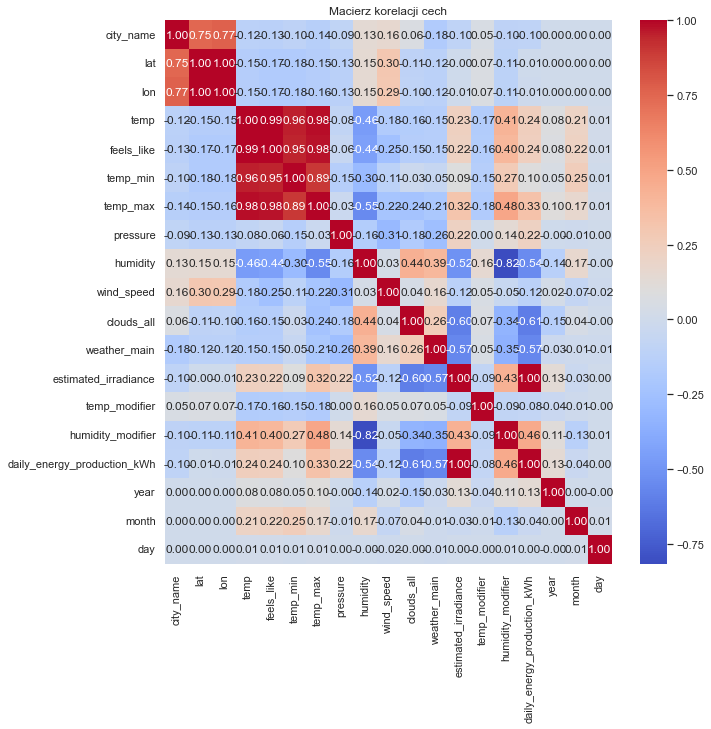

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obliczenie macierzy korelacji
correlation_matrix = data.corr()

# Wizualizacja macierzy korelacji
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Macierz korelacji cech')
plt.show()


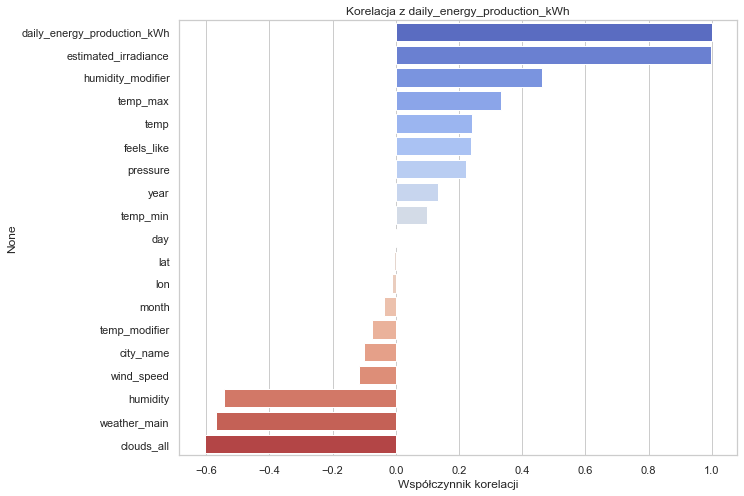

daily_energy_production_kWh    1.000000
estimated_irradiance           0.998920
humidity_modifier              0.461786
temp_max                       0.331377
temp                           0.242039
feels_like                     0.236218
pressure                       0.220573
year                           0.134734
temp_min                       0.097158
day                            0.002996
lat                           -0.006800
lon                           -0.012080
month                         -0.036606
temp_modifier                 -0.076785
city_name                     -0.099420
wind_speed                    -0.115163
humidity                      -0.543146
weather_main                  -0.567768
clouds_all                    -0.605441
Name: daily_energy_production_kWh, dtype: float64

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obliczenie macierzy korelacji
correlation_matrix = data.corr()

# Wyświetlenie korelacji zmiennej celu z innymi zmiennymi
correlation_target = correlation_matrix['daily_energy_production_kWh'].sort_values(ascending=False)

# Wykres korelacji
plt.figure(figsize=(10, 8))
sns.barplot(y=correlation_target.index, x=correlation_target.values, hue=correlation_target.index, palette='coolwarm', legend=False)
plt.title('Korelacja z daily_energy_production_kWh')
plt.xlabel('Współczynnik korelacji')
plt.show()

correlation_target

In [98]:
# import seaborn as sns
# import numpy as np
# import matplotlib.pyplot as plt

# #Convert date columns to datetime, assuming the column name is 'date'
# data['date'] = pd.to_datetime(data['date'], errors='coerce')  # errors='coerce' will convert unparseable strings to NaT

# # Selecting only numeric columns for correlation
# numeric_data = data.select_dtypes(include=[np.number])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


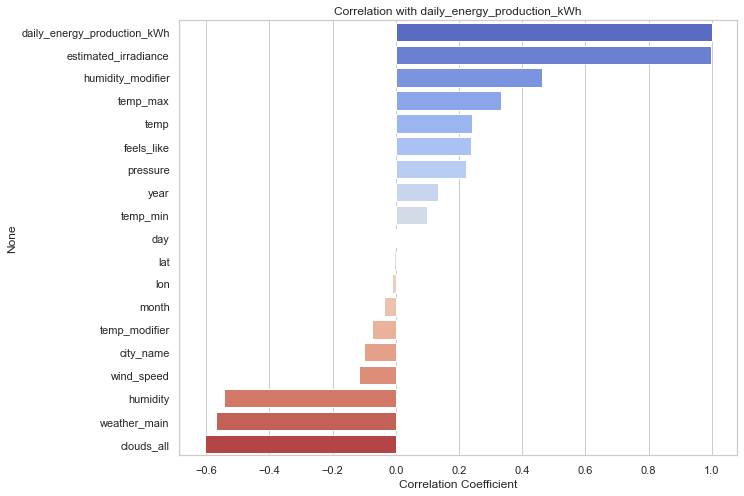

daily_energy_production_kWh    1.000000
estimated_irradiance           0.998920
humidity_modifier              0.461786
temp_max                       0.331377
temp                           0.242039
feels_like                     0.236218
pressure                       0.220573
year                           0.134734
temp_min                       0.097158
day                            0.002996
lat                           -0.006800
lon                           -0.012080
month                         -0.036606
temp_modifier                 -0.076785
city_name                     -0.099420
wind_speed                    -0.115163
humidity                      -0.543146
weather_main                  -0.567768
clouds_all                    -0.605441
Name: daily_energy_production_kWh, dtype: float64


In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Displaying the correlation of the target variable with other variables.
correlation_target = correlation_matrix['daily_energy_production_kWh'].sort_values(ascending=False)

# Plotting the correlation
plt.figure(figsize=(10, 8))
sns.barplot(y=correlation_target.index, x=correlation_target.values, hue=correlation_target.index, palette='coolwarm', legend=False)
plt.title('Correlation with daily_energy_production_kWh')
plt.xlabel('Correlation Coefficient')

# If you decide you don't want a legend, you can disable it using plt.legend().
plt.legend().set_visible(False)

plt.show()

# Print the sorted correlation values.
print(correlation_target)

#### Analiza korelacji ujawniła kilka interesujących zależności:

- Zmienna estimated_irradiance ma bardzo wysoką korelację (prawie 1) z daily_energy_production_kWh, co wskazuje, że jest to kluczowy czynnik wpływający na produkcję energii.
- Inne zmienne takie jak humidity_modifier, temp_max, temp, i feels_like również pokazują pozytywną korelację z produkcją energii, chociaż są znacznie słabsze.
- Zmienne takie jak humidity i clouds_all mają silną ujemną korelację z produkcją energii, co oznacza, że wyższe wartości tych zmiennych mogą prowadzić do mniejszej produkcji energii.

#### 3. Wybór modeli i cech do modelowania

Na podstawie analizy korelacji, warto wybrać modele, które najlepiej radzą sobie z regresją, ponieważ mamy do czynienia z ciągłą zmienną celu (produkcja energii). Oto modele z sklearn, które weźmiemy pod uwagę:

1. Regresja liniowa (dobra dla liniowych zależności)
2. Drzewo decyzyjne (może modelować nieliniowe zależności)
3. RandomForest (ensemble drzew decyzyjnych, bardziej rozbudowany i zazwyczaj bardziej dokładny)
4. XGBoost (bardzo skuteczny model gradient boosting)

**Uwaga:**
Modele takie jak NearestCentroid, KNeighborsClassifier, Naive Bayes, i SVC są zazwyczaj stosowane do klasyfikacji, więc nie będą odpowiednie do naszego przypadku.

#### Przygotowanie danych do modelowania

Wybiorę następujące cechy na podstawie korelacji:

- estimated_irradiance
- humidity_modifier
- temp_max
- temp
- feels_like
- pressure
- humidity
- clouds_all
- year
- month

**Cechy do zachowania:**
- estimated_irradiance - Ze względu na bardzo wysoką korelację z produkcją energii, jest to kluczowa cecha do modelowania.
- humidity_modifier - Posiada umiarkowaną pozytywną korelację, co może być przydatne.
- temp - Podobnie jak temp_max, ale warto zastanowić się, czy nie jest redundantna w stosunku do temp_max.
- feels_like, pressure - Posiadają pewien potencjalny wpływ na model, mogą być rozważone w zależności od wyników wstępnych modeli.
- Geograficzne i czasowe (year, month, day, lat, lon) - Jeżeli chcesz analizować i wizualizować wyniki w kontekście czasowym i geograficznym.

**Cechy do usunięcia:**
- temp_min, temp_max - Może być redundantna, gdyż mamy już temp.
- temp_modifier - Niska korelacja, możliwe, że nie wnosi dużo do modelu.
- city_name, weather_main, clouds_all - Mają ujemne korelacje i mogą nie być potrzebne w modelu, jeżeli skupiamy się na bezpośrednich wpływach meteorologicznych i irradiacjiw.
- wind_speed, humidity - Ich korelacje są niskie lub negatywne, mogą być mniej istotne dla modelu, zwłaszcza jeśli chcesz uproszczenia.

**POPORAWIC TEKST BO INNE CECHY**

In [100]:
from sklearn.model_selection import train_test_split

# Usunięcie zbędnych cech
data = data.drop(columns=['temp_max', 'temp_min'])

# Wybór cech i celu
# Zaktualizowany wybór cech
features = [
    'temp', 'estimated_irradiance', 'humidity_modifier', 'pressure', 'feels_like',
    'year', 'month', 'day', 'lat', 'lon', 'city_name', 'clouds_all', 'weather_main'
]
X = data[features]
y = data['daily_energy_production_kWh']

# Podział na zbiory treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Dane zostały podzielone na zbiory treningowe i testowe. Mamy 39446 obserwacji w zbiorze treningowym i 9862 w zbiorze testowym, przy wykorzystaniu 8 cech.

#### 4. Trenowanie modeli na ustawieniach domyślnych

Zaczniemy od trenowania czterech wybranych modeli:

1. Regresja liniowa
2. Drzewo decyzyjne
3. Random Forest
4. XGBoost

**Regresja liniowa:**
Regresja liniowa jest jednym z podstawowych algorytmów używanych w analizie regresji. Zakłada ona liniową zależność między zmiennymi niezależnymi (cechy) a zmienną zależną (wartością przewidywaną). Celem regresji liniowej jest znalezienie najlepszej dopasowanej linii (lub hiperpłaszczyzny w przypadku wielu zmiennych niezależnych), która minimalizuje błąd predykcji. Proces ten polega na znalezieniu zestawu parametrów (wag), które minimalizują sumę kwadratów różnic między wartościami przewidywanymi a rzeczywistymi. Regresja liniowa jest stosowana w przypadku, gdy zmienna zależna jest ciągła.

**Drzewo decyzyjne:**
Drzewo decyzyjne jest modelem predykcyjnym używanym zarówno w zadaniach klasyfikacji, jak i regresji. Model ten składa się z drzewa struktury podziałów decyzyjnych. W każdym węźle drzewa następuje podział danych na podstawie wartości jednej z cech, aby zminimalizować nieczystość węzła (np. entropię w przypadku klasyfikacji). Proces ten jest rekursywnie powtarzany, aż do osiągnięcia warunku stopu, np. maksymalnej głębokości drzewa lub minimalnej liczby próbek w liściach. W przypadku regresji, liście drzewa zawierają średnią wartość zmiennej zależnej dla odpowiednich grup danych.

**Random Forest:**
Random Forest jest algorytmem zbudowanym na bazie drzew decyzyjnych. Tworzy on wiele drzew decyzyjnych w procesie zwanym baggingiem (z ang. bootstrap aggregating), gdzie każde drzewo jest uczone na losowym podzbiorze danych treningowych. Następnie, przewidywanie w Random Forest jest wykonywane poprzez uśrednienie przewidywań wszystkich drzew decyzyjnych w przypadku klasyfikacji lub uśrednienie przewidywanych wartości w przypadku regresji. Random Forest jest odporny na overfitting i zwykle oferuje lepszą wydajność niż pojedyncze drzewo decyzyjne.

**XGBoost:**
XGBoost (Extreme Gradient Boosting) to technika boostingowa, która skupia się na sekwencyjnym trenowaniu wielu słabych modeli predykcyjnych, takich jak drzewa decyzyjne, w celu utworzenia silnego modelu. XGBoost wykorzystuje technikę gradient boosting, w której każdy kolejny model jest uczony w taki sposób, aby minimalizować błąd predykcji poprzednich modeli. XGBoost wprowadza dodatkowe innowacje, takie jak regularyzacja drzew, oszacowanie drugiego rzędu (dla bardziej stabilnych prognoz) i optymalizacja obliczeń, aby zapewnić wyższą wydajność i dokładność. Jest powszechnie stosowany w konkursach na platformie Kaggle oraz w różnych zastosowaniach przemysłowych, gdzie precyzja ma kluczowe znaczenie.

Ocena modelow nastapi przy użyciu metryk takich jak średni błąd kwadratowy (MSE) i średni błąd bezwzględny (MAE) na zbiorze testowym

**Średni błąd kwadratowy (MSE):**
MSE jest średnią z kwadratów różnic pomiędzy rzeczywistymi (obserwowanymi) wartościami a przewidywanymi wartościami. Jest to popularna metryka używana do oceny jakości regresji, ponieważ większe błędy są bardziej karane niż mniejsze błędy (poprzez kwadratowanie różnicy). MSE może przyjąć wartości od 0 do nieskończoności, gdzie niższa wartość wskazuje lepszą jakość predykcji. Oczekuje się, że niższa wartość MSE będzie lepsza.

**Średni błąd bezwzględny (MAE):**
MAE jest średnią z bezwzględnych różnic pomiędzy rzeczywistymi (obserwowanymi) wartościami a przewidywanymi wartościami. Jest to inna popularna metryka do oceny jakości regresji. MAE oblicza średnią bezwzględną odległość pomiędzy przewidywanymi a rzeczywistymi wartościami, co sprawia, że nie jest tak wrażliwa na duże błędy jak MSE. MAE również może przyjmować wartości od 0 do nieskończoności, gdzie niższa wartość wskazuje lepszą jakość predykcji. Oczekuje się, że niższa wartość MAE będzie lepsza.


**Metryka  R2 - Współczynnik determinacji**
Współczynnik determinacji, znany również jako  2R2, to statystyczna miara jakości dopasowania modelu regresyjnego. Metryka ta jest szczególnie użyteczna do oceny skuteczności modelu w kontekście wyjaśnienia zmienności zmiennej zależnej przez zmienne niezależne. Oto kluczowe aspekty metryki  2R2:

Definicja
- R2 jest zdefiniowany jako proporcja wariancji zmiennej zależnej, która jest przewidywana z niezależnych zmiennych.
- Wartość  2R2 wynosi od 0 do 1, gdzie 0 oznacza, że model nie wyjaśnia żadnej zmienności zmiennej zależnej, a 1 oznacza, że model wyjaśnia całą zmienność zmiennej zależnej.

Interpretacja
- Wysoki  2R2: Wartość bliska 1 wskazuje, że większość zmienności zmiennej zależnej można wyjaśnić za pomocą modelu. Innymi słowy, model dobrze pasuje do danych.
- Niski  2R2: Wartość bliska 0 sugeruje, że model nie wyjaśnia dobrze zmienności danych; może to oznaczać, że istotne zmienne lub zależności nie są włączone w model.

Uwagi
- Zastosowanie:  2R2 jest często używane w modelach liniowych, ale może być również stosowane w nieliniowych modelach regresyjnych.
- Ograniczenia: Wysoki  2R2 nie zawsze oznacza, że model jest idealny. Model może cierpieć na problemy takie jak nadmierne dopasowanie (overfitting), gdzie model jest zbyt skomplikowany i dokładnie dopasowuje się do danych treningowych kosztem ogólnej zdolności do generalizacji.
- Zależność od liczby predyktorów: Dodawanie więcej zmiennych do modelu może sztucznie zwiększać  2R2, nawet jeśli te dodatkowe zmienne nie poprawiają rzeczywiście modelu. Alternatywną miarą, która uwzględnia liczbę predyktorów, jest skorygowany  2R2.

Przykład praktyczny
- Model z  2R2 równym 0.9 sugeruje, że 90% zmienności w danych można wyjaśnić przez model, co jest zazwyczaj uznawane za bardzo dobry wynik, pod warunkiem, że model nie jest nadmiernie dopasowany.

In [101]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

# Inicjalizacja modeli
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Trenowanie modeli i zbieranie wyników
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

# Wyświetlenie wyników
for name, metrics in results.items():
    print(f"{name} - MSE: {metrics['MSE']:.6f}, MAE: {metrics['MAE']:.6f}, R2: {metrics['R2']:.6f}")


Linear Regression - MSE: 0.013714, MAE: 0.069622, R2: 0.999489
Decision Tree - MSE: 0.000000, MAE: 0.000000, R2: 1.000000
Random Forest - MSE: 0.000002, MAE: 0.000024, R2: 1.000000
XGBoost - MSE: 0.000603, MAE: 0.001377, R2: 0.999978


**Obserwacje:**
Wyniki te sugerują, że modele mogły ulec nadmiernemu dopasowaniu do danych treningowych. Warto zastosować kilka strategii, aby sprawdzić i potencjalnie poprawić ogólną skuteczność i generalizację modeli.

1. Walidacja Krzyżowa
Aby zminimalizować ryzyko nadmiernego dopasowania i lepiej ocenić skuteczność modelu na danych, które nie były widziane podczas trenowania, możesz zastosować walidację krzyżową. Pozwala ona na ocenę, jak model będzie się zachowywał na różnych podzbiorach danych.

2. Regularyzacja Modeli
Dla modeli takich jak regresja liniowa, lasy losowe i XGBoost, rozważ wprowadzenie parametrów regularyzacji, które pomogą w ograniczeniu złożoności modelu:

- Regresja liniowa: Można użyć Ridge lub Lasso, które dodają odpowiednio karę  2L2 lub  1L1 do funkcji kosztu.

- Las losowy: Zwiększenie parametru min_samples_leaf (minimalna liczba próbek wymagana w liściu) lub max_depth (maksymalna głębokość drzewa) może pomóc ograniczyć nadmierne dopasowanie.

- XGBoost: Parametry takie jak gamma (minimalna redukcja strat wymagana do dalszego podziału), max_depth i lambda (regularyzacja L2) mogą być dostosowane, aby kontrolować złożoność modelu.

3. Analiza Błędów Residuów
Sprawdź residua, czyli różnice między wartościami przewidywanymi a rzeczywistymi, aby zobaczyć, czy istnieją jakieś wzorce błędów. Jeśli residua nie są losowo rozłożone wokół zera, może to wskazywać na problem z modelem, taki jak skośność, heteroskedastyczność lub niewłaściwie uchwycone nieliniowości.

#### 1. Walidacja Krzyżowa

In [102]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Lista modeli
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Walidacja krzyżowa dla każdego modelu
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"{name} - Średni MSE z walidacji krzyżowej: {-scores.mean():.5f}")



Linear Regression - Średni MSE z walidacji krzyżowej: 0.01361
Decision Tree - Średni MSE z walidacji krzyżowej: 0.00007
Random Forest - Średni MSE z walidacji krzyżowej: 0.00006
XGBoost - Średni MSE z walidacji krzyżowej: 0.00057


#### 2. Regularyzacja Modeli

##### Regresja Liniowa z Regularyzacją (Lasso i Ridge)

In [103]:
# Lasso Regression (L1)
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=0.01, random_state=42)  # alpha to parametr regularyzacji
lasso_scores = cross_val_score(lasso_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Lasso Regression - Średni MSE: {-lasso_scores.mean():.5f}")



Lasso Regression - Średni MSE: 0.04880


In [104]:
# Ridge Regression (L2)
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=0.01, random_state=42)
ridge_scores = cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Ridge Regression - Średni MSE: {-ridge_scores.mean():.5f}")


Ridge Regression - Średni MSE: 0.01361


##### Random Forest z regularyzacją

In [105]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42, max_depth=10, min_samples_leaf=4, max_features=0.8)
rf_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"Random Forest - Średni MSE: {-rf_scores.mean():.5f}")


Random Forest - Średni MSE: 0.00081


##### XGBoost z regularyzacją

In [106]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42, max_depth=6, gamma=0.1, reg_lambda=1.0, reg_alpha=0.1)
xgb_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"XGBoost - Średni MSE: {-xgb_scores.mean():.5f}")


XGBoost - Średni MSE: 0.00047


Wyniki regularyzacji i walidacji krzyżowej
Twoje wyniki pokazują interesujące różnice w skuteczności modeli po zastosowaniu regularyzacji. Oto krótka analiza każdego z modeli na podstawie średniego MSE uzyskanego w walidacji krzyżowej:

Lasso Regression
- Średni MSE: 0.04880
- Lasso zazwyczaj stosuje się, gdy podejrzewamy, że tylko niektóre cechy mają znaczący wpływ na zmienną zależną, ponieważ Lasso może redukować współczynniki mniej istotnych zmiennych do zera. Wyższy MSE w porównaniu do innych modeli może wskazywać na to, że większość cech ma znaczenie, lub że parametr regularyzacji (alpha) był zbyt wysoki.

Ridge Regression
- Średni MSE: 0.01361
- Ridge jest bardziej odpowiedni w sytuacjach, gdzie wiele cech jest wzajemnie skorelowanych. Niski MSE w porównaniu do Lasso sugeruje, że większość cech w zestawie danych ma wpływ na zmienną zależną i że te cechy są współliniowe.

Random Forest
- Średni MSE: 0.00081
- Random Forest, nawet z podstawową regularyzacją, nadal pokazuje bardzo dobre wyniki, co wskazuje na jego wysoką zdolność do modelowania złożonych nieliniowości bez nadmiernego dopasowania, dzięki zastosowaniu losowości w wyborze cech i próbek przy budowie drzew.

XGBoost
- Średni MSE: 0.00047
- XGBoost, ze stosunkowo agresywnymi ustawieniami regularyzacji, osiągnął najlepsze wyniki. To wskazuje na to, że odpowiednie dobranie parametrów modelu pozwala na bardzo dokładne przewidywania z zachowaniem generalizacji.

Zalecenia
1. Dalsze dostosowywanie regularyzacji: Dla modeli Lasso i Ridge, może warto eksperymentować z różnymi wartościami parametru alpha, aby znaleźć idealny balans między biasem a wariancją.
2. Analiza ważności cech w Random Forest i XGBoost: Sprawdzenie, które cechy są uznawane przez te modele za najważniejsze, może dać dalsze wskazówki, jak zoptymalizować zestaw danych.
3. Zastosowanie Grid Search: Dla modeli Random Forest i XGBoost możesz zastosować Grid Search, aby znaleźć optymalne kombinacje ich hiperparametrów.
Ewaluacja na zewnętrznym zestawie danych: Jeśli to możliwe, przetestuj wybrane modele na zupełnie nowym zestawie danych, aby zobaczyć, jak radzą sobie w praktyce.

#### 3. Analiza Błędów Residuów

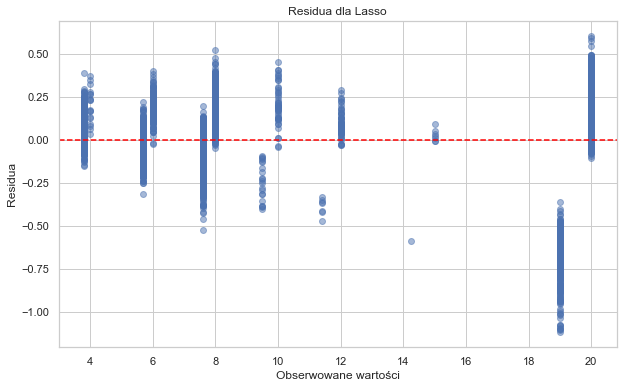

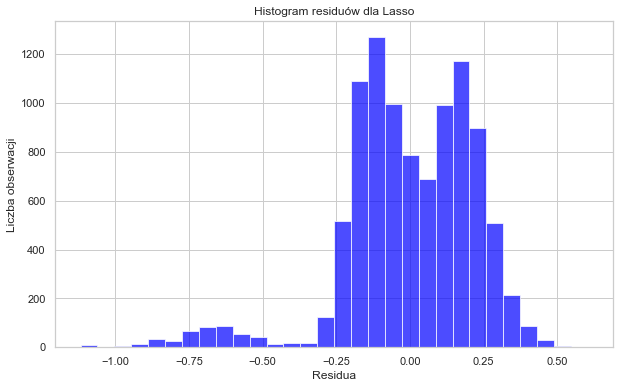

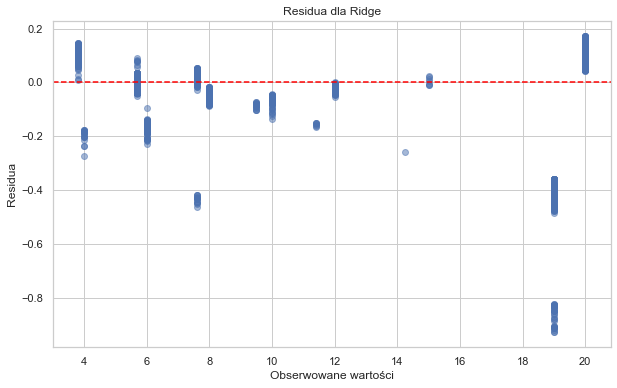

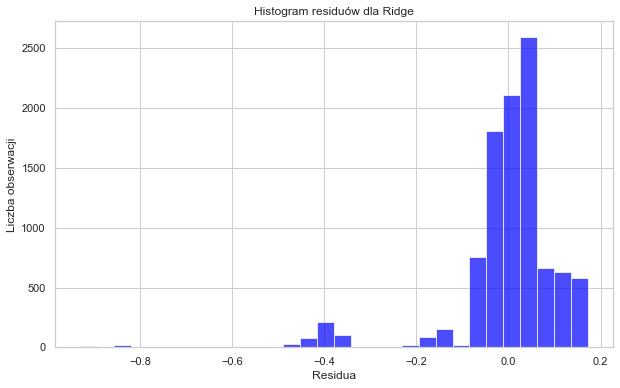

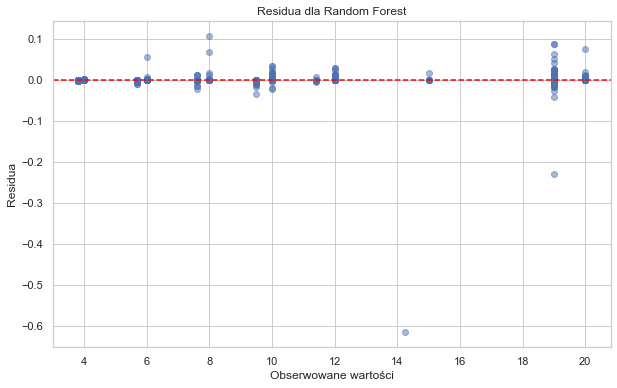

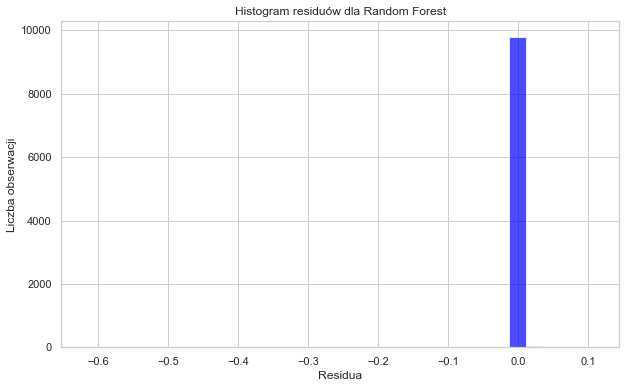

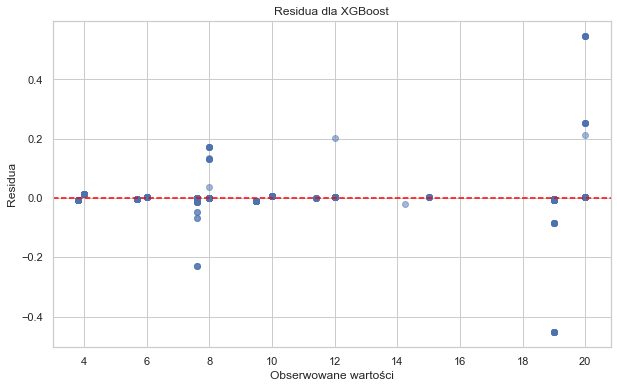

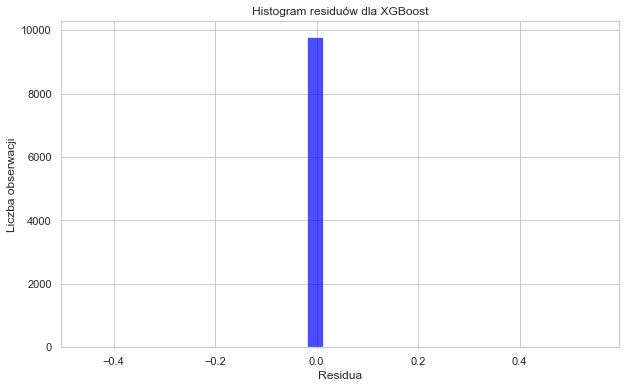

In [107]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Słownik do przechowywania modeli i ich nazw
models = {
    'Lasso': Lasso(alpha=0.01, random_state=42),
    'Ridge': Ridge(alpha=0.01, random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, max_depth=10, min_samples_leaf=4, max_features=0.8),
    'XGBoost': XGBRegressor(random_state=42, max_depth=6, gamma=0.1, reg_lambda=1.0, reg_alpha=0.1)
}

# Trenowanie modeli, przewidywanie i obliczanie residuów
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    residuals = y_test - predictions
    
    # Wykres residuów
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'Residua dla {name}')
    plt.xlabel('Obserwowane wartości')
    plt.ylabel('Residua')
    plt.show()
    
    # Histogram residuów
    plt.figure(figsize=(10, 6))
    plt.hist(residuals, bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram residuów dla {name}')
    plt.xlabel('Residua')
    plt.ylabel('Liczba obserwacji')
    plt.show()



Analiza Residuów
1. Lasso Regression
• Wykres residuów pokazuje, że dla większych wartości obserwowanych, residua są bardziej rozproszone, co sugeruje heteroskedastyczność (niestałość wariancji residuów). Residua nie są symetrycznie rozłożone wokół linii y=0, co wskazuje na obciążenie modelu.
• Histogram residuów pokazuje, że rozkład residuów nie jest normalny i skupia się na lewej stronie zera, co może wskazywać na błąd w modelu lub przewidywanie przez model systematycznie za niskich wartości.
2. Ridge Regression
• Residua wykazują mniej ekstremalne wartości w porównaniu do Lasso, co sugeruje mniejszą wariancję błędów. Jednak nadal można zauważyć pewne wartości odstające.
• Histogram wskazuje na lekkie przesunięcie residuów w kierunku wartości ujemnych, co może wskazywać na niewystarczające dostosowanie modelu do danych.
3. Random Forest
• Residua są stosunkowo równomiernie rozłożone wokół linii zerowej i ograniczone do niewielkich wartości, co jest dobrym znakiem. Oznacza to, że model jest dobrze dopasowany, z minimalnymi błędami przewidywania.
• Histogram wskazuje na bardzo skoncentrowany rozkład residuów, co jest typowe dla bardzo dobrze działających modeli.
4. XGBoost
• Residua dla XGBoost również są dobrze wycentrowane wokół linii zerowej, co wskazuje na dobre dopasowanie modelu.
Histogram podobnie jak dla Random Forest pokazuje skoncentrowany rozkład, ale z jeszcze mniejszą wariancją, co oznacza bardzo dokładne przewidywania.

**Wnisoki**

- Model Lasso i Ridge: Wykazywały pewne oznaki niedopasowania oraz heteroskedastyczności. Może to oznaczać potrzebę dalszej regulacji hiperparametrów, zmiany w selekcji cech lub zastosowania innego podejścia do modelowania tych danych.

- Random Forest i XGBoost: Pokazały wyjątkowo dobrą zdolność do dopasowania z minimalnymi błędami residuów. Jednakże ich idealne dopasowanie w testach może również sugerować nadmierne dopasowanie, chociaż mniejsza wariancja residuów sugeruje, że model jest bardzo skuteczny.

**Dalsze kroki**
- Możesz rozważyć ponowne skalowanie danych lub zastosowanie innych technik przetwarzania wstępnego dla Lasso i Ridge.

- Ponieważ modele drzewiaste (Random Forest i XGBoost) osiągają bardzo dobre wyniki, sprawdzenie ich wydajności na nowych, niezależnych zestawach danych lub za pomocą surowszych metod walidacji krzyżowej mogłoby być kolejnym krokiem, aby upewnić się, że te wyniki są wiarygodne i reprezentatywne dla ogólnej zdolności modelu do generalizacji.

**Surowsza walidacja krzyżowa**

In [108]:
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# Konfiguracja Repeated K-Fold CV
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

# Model Random Forest
rf = RandomForestRegressor(random_state=42, max_depth=10, min_samples_leaf=4)
rf_scores = cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error')
print(f"Random Forest - Średni MSE: {-rf_scores.mean():.5f}")

# Model XGBoost
xgb = XGBRegressor(random_state=42, max_depth=6, gamma=0.1, reg_lambda=1.0, reg_alpha=0.1)
xgb_scores = cross_val_score(xgb, X, y, cv=cv, scoring='neg_mean_squared_error')
print(f"XGBoost - Średni MSE: {-xgb_scores.mean():.5f}")



Random Forest - Średni MSE: 0.00056
XGBoost - Średni MSE: 0.00051


Wyniki Surowszej Walidacji Krzyżowej
Twoje wyniki pokazują bardzo niskie wartości MSE dla obu modeli, Random Forest i XGBoost, co jest optymistycznym sygnałem dotyczącym ich zdolności do dokładnego modelowania danych:

Random Forest - Średni MSE: 0.00056
XGBoost - Średni MSE: 0.00051
Te wyniki sugerują, że oba modele są bardzo skuteczne i stabilne, oferując wysoką dokładność przewidywań. Niska wartość MSE wskazuje na małe błędy między przewidywanymi a rzeczywistymi wartościami, co jest kluczowe dla zastosowań, gdzie precyzja jest ważna.

Interpretacja Wyników
Stabilność Modeli: Wyniki sugerują, że oba modele dobrze radzą sobie z różnorodnością danych podczas walidacji krzyżowej z wieloma podziałami. Daje to pewność, że modele te mogą być skuteczne również na nowych, niewidocznych dotąd danych.

Porównanie Modeli: XGBoost osiągnął nieznacznie lepsze wyniki niż Random Forest, co może wskazywać na lepszą zdolność tego modelu do uchwycenia złożoności danych i efektywniejsze radzenie sobie z nieliniowościami w zbiorze danych.

#### 5. Optymalizacja hiperparametrów

Rozpocznijmy proces optymalizacji hiperparametrów dla modeli drzewiastych przy użyciu metody Grid Search, co pozwoli nam znaleźć najlepsze ustawienia dla każdego modelu, a tym samym zminimalizować błąd predykcji. Zastosujemy te metody również dla XGBoost, gdzie dodatkowo będziemy mogli regulować learning rate oraz inne specyficzne parametry.

**Optymalizacja hiperparametrów dla Random Forest**
- n_estimators: liczba drzew w lesie
- max_depth: maksymalna głębokość drzew
- min_samples_split: minimalna liczba próbek wymagana do podziału wewnętrznego węzła

**Optymalizacja hiperparametrów dla XGBoost**
- n_estimators: liczba drzew
- learning_rate: współczynnik uczenia się
- max_depth: maksymalna głębokość każdego drzewa

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Parametry dla Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10, 20]
}

# Utworzenie modelu Random Forest
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search_rf.fit(X_train, y_train)

# Najlepsze parametry dla Random Forest
best_params_rf = grid_search_rf.best_params_
print("Najlepsze parametry dla Random Forest:", best_params_rf)




Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   2.6s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   2.7s
[CV] END .max_depth=10, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   4.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   5.7s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   9.3s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   8.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=   9.3s
[CV] END max_depth=10, min_samples_split=10, n_estimators=50; total time=   2.4s
[CV] END max_depth=10, min_samples_split=10, n_estimators=50; total time=   2.5s
[CV] END max_depth=10, min_samples_split=10, n_e

In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Parametry dla XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Utworzenie modelu XGBoost
xgb = XGBRegressor(random_state=42)
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search_xgb.fit(X_train, y_train)

# Najlepsze parametry dla XGBoost
best_params_xgb = grid_search_xgb.best_params_
print("Najlepsze parametry dla XGBoost:", best_params_xgb)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=6, n_estimators=100; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=6, n_es

**Analiza i Trening na Najlepszych Parametrach**

In [111]:
#Random Forest
# Trening Random Forest z najlepszymi parametrami
best_rf = RandomForestRegressor(max_depth=10, min_samples_split=2, n_estimators=50, random_state=42)
best_rf.fit(X_train, y_train)
rf_predictions = best_rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print(f"Random Forest - MSE: {rf_mse:.6f}, MAE: {rf_mae:.6f}, R^2: {rf_r2:.6f}")



Random Forest - MSE: 0.000002, MAE: 0.000022, R^2: 1.000000


In [112]:
#XGBoost
# Trening XGBoost z najlepszymi parametrami
best_xgb = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)
best_xgb.fit(X_train, y_train)
xgb_predictions = best_xgb.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)


print(f"XGBoost - MSE: {xgb_mse:.6f}, MAE: {xgb_mae:.6f}, R^2: {xgb_r2:.6f}")



XGBoost - MSE: 0.000431, MAE: 0.001959, R^2: 0.999984


In [113]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Inicjalizacja modeli
models_default = {
    'Linear Regression (Default)': LinearRegression(),
    'Decision Tree (Default)': DecisionTreeRegressor(random_state=42),
    'Random Forest (Default)': RandomForestRegressor(random_state=42),
    'XGBoost (Default)': XGBRegressor(random_state=42)
}

models_best = {
    'Linear Regression (Best Params)': LinearRegression(),
    'Decision Tree (Best Params)': DecisionTreeRegressor(random_state=42),
    'Random Forest (Best Params)': RandomForestRegressor(max_depth=10, min_samples_split=2, n_estimators=50, random_state=42),
    'XGBoost (Best Params)': XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)
}

models_reg = {
    'Lasso Regression': Lasso(alpha=0.01, random_state=42),
    'Ridge Regression': Ridge(alpha=0.01, random_state=42),
    'Random Forest (Regularized)': RandomForestRegressor(random_state=42, max_depth=10, min_samples_leaf=4, max_features=0.8),
    'XGBoost (Regularized)': XGBRegressor(random_state=42, max_depth=6, gamma=0.1, reg_lambda=1.0, reg_alpha=0.1)
}

# Trenowanie modeli i zbieranie wyników
def get_metrics(models):
    results = {}
    for name, model in models.items():
        scores_mse = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
        mse_mean = -scores_mse.mean()
        
        scores_mae = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
        mae_mean = -scores_mae.mean()
        
        scores_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
        r2_mean = scores_r2.mean()
        
        results[name] = {'MSE': mse_mean, 'MAE': mae_mean, 'R2': r2_mean}
    return results

results_default = get_metrics(models_default)
results_best = get_metrics(models_best)
results_reg = get_metrics(models_reg)

# Tworzenie ramek danych
df_default = pd.DataFrame(results_default).T
df_default.index.name = 'Model (Default Params)'

df_best = pd.DataFrame(results_best).T
df_best.index.name = 'Model (Best Params)'

df_reg = pd.DataFrame(results_reg).T
df_reg.index.name = 'Model (Regularized)'

# Połączenie ramek danych
df_combined = pd.concat([df_default, df_best, df_reg])

print(df_combined)




                                      MSE       MAE        R2
Linear Regression (Default)      0.013606  0.070029  0.999495
Decision Tree (Default)          0.000071  0.000095  0.999998
Random Forest (Default)          0.000059  0.000137  0.999998
XGBoost (Default)                0.000567  0.001284  0.999980
Linear Regression (Best Params)  0.013606  0.070029  0.999495
Decision Tree (Best Params)      0.000071  0.000095  0.999998
Random Forest (Best Params)      0.000062  0.000141  0.999998
XGBoost (Best Params)            0.000491  0.001912  0.999982
Lasso Regression                 0.048796  0.171181  0.998112
Ridge Regression                 0.013606  0.069958  0.999495
Random Forest (Regularized)      0.000815  0.000816  0.999964
XGBoost (Regularized)            0.000472  0.002596  0.999983


**Wnisoek:**
- wybrany model to: "Random Forest (Regularized)

In [114]:
import joblib


# Inicjalizacja modelu
rf_model_reg = RandomForestRegressor(random_state=42, max_depth=10, min_samples_leaf=4, max_features=0.8)

# Trenowanie modelu na całych danych
rf_model_reg.fit(X, y)

# Ścieżka do zapisania modelu
model_path = '../2. Data/ML_models/random_forest_regularized_model.joblib'

# Zapisanie modelu do pliku
joblib.dump(rf_model_reg, model_path)

print("Model został zapisany do:", model_path)

Model został zapisany do: ../2. Data/ML_models/random_forest_regularized_model.joblib


#### 6. Ekstrapolacja w przyszłość

Przechodzimy teraz do ekstrapolacji przewidywań na przyszłość, korzystając z zoptymalizowanego modelu Random Forest. To etap, na którym będziemy korzystać z modelu do prognozowania przyszłej produkcji energii na lata 2024-2035, zarówno na poziomie rocznym, jak i miesięcznym.

1. Przygotowanie danych przyszłych
Najpierw musimy przygotować dane wejściowe dla modelu, które będą odpowiadać przyszłym warunkom. To może obejmować przewidywanie lub ekstrapolację cech takich jak 'estimated_irradiance', 'humidity_modifier', 'pressure' itd., w zależności od dostępności przyszłych danych lub prognoz

2. Wykorzystanie modelu do przewidywania
Następnie użyjemy zapisanego modelu do wygenerowania prognoz produkcji energii na podstawie przygotowanych danych.

3. Wizualizacja wyników
Wizualizacja wyników pomoże zrozumieć, jak model przewiduje zmiany w produkcji energii w ciągu roku.

**tutaj chby trzeba wgrac data_ml_processed i na niej pracowac**

In [115]:
import pandas as pd
import numpy as np

# Załadowanie danych
data_path = '../2. Data/processed/data_ml_processed.csv'
data = pd.read_csv(data_path)

# Wczytanie danych historycznych
historical_data = data.copy()

# Calculate monthly averages for key parameters from historical data
monthly_avg_values = historical_data.groupby(['month']).mean().reset_index()

# Wybieramy unikalne lokalizacje, ich szerokości i długości geograficzne
unique_cities = data[['city_name', 'lat', 'lon']].drop_duplicates()

# Generowanie przyszłych dat
dates = pd.date_range(start='2024-01-01', end='2035-12-31', freq='D')  # Dziennie dane

future_data_list = []
for index, row in unique_cities.iterrows():
        for date in dates:
            month_avg = monthly_avg_values[monthly_avg_values['month'] == date.month].iloc[0]
            day_data = {
                'temp': np.random.normal(loc=month_avg['temp']),
                'estimated_irradiance': np.random.normal(loc=month_avg['estimated_irradiance']),
                'humidity_modifier': month_avg['humidity_modifier'],
                'pressure': month_avg['pressure'],
                'feels_like': np.random.normal(loc=month_avg['feels_like']),
                'year': date.year,
                'month': date.month,
                'day': date.day,
                'lat': row['lat'],
                'lon': row['lon'],
                'city_name': row['city_name'],
                'clouds_all': np.random.normal(loc=month_avg['clouds_all']),
                'weather_main': np.random.choice(historical_data['weather_main'].unique())
            }
            future_data_list.append(day_data)

# Tworzenie DataFrame z przyszłymi danymi
future_data = pd.DataFrame(future_data_list)


# Teraz można użyć tego DataFrame do predykcji za pomocą załadowanego modelu


Tworzenie danych do przewidywania w podanym kodzie odbywa się w kilku krokach i wykorzystuje połączenie średnich wartości miesięcznych z pewnymi losowymi odchyleniami, aby zasymulować zmienność. Oto jak to jest realizowane:

1. Wybór średnich miesięcznych wartości:

Dla każdego dnia w zakresie dat (od 2024-01-01 do 2035-12-31), kod najpierw wyszukuje średnie wartości dla danego miesiąca z monthly_avg_values. month_avg to wiersz zawierający średnie wartości dla miesiąca odpowiadającego danemu dniowi (date.month).

2. Generowanie danych na podstawie średnich wartości:

- temp (temperatura): Losowe wartości są generowane na podstawie normalnego rozkładu z średnią równą średniej temperaturze dla danego miesiąca (month_avg['temp']) i domyślnym odchyleniem standardowym.
- estimated_irradiance (przewidywana irradiancja): Podobnie jak temperatura, wartości są generowane losowo z normalnego rozkładu wokół średniej wartości irradiancji dla miesiąca.
- humidity_modifier, pressure (modyfikator wilgotności, ciśnienie): Bezpośrednie użycie średnich miesięcznych wartości, bez dodatkowych losowych zmian.
- feels_like (odczuwalna temperatura): Generowane losowo z normalnego rozkładu podobnie jak temperatura.
- clouds_all (zachmurzenie): Generowane losowo z normalnego rozkładu wokół średniej wartości zachmurzenia dla miesiąca.

3. Dodatkowe informacje geograficzne i pogodowe:

- lat (szerokość geograficzna) i lon (długość geograficzna): Bezpośrednio z wiersza odpowiadającego danej lokalizacji.
- city_name: Nazwa miasta również bezpośrednio z wiersza.
- weather_main: Losowo wybrany typ pogody z unikalnych wartości występujących w danych historycznych.

4. Tworzenie rekordu danych:

Każdy day_data reprezentuje dane pogodowe i geograficzne dla jednego dnia, w których zasymulowano zarówno stałość (średnie wartości) jak i zmienność (losowe odchylenia) warunków pogodowych.

**Tworzenie danych do przewidywania w podanym kodzie można poprawić na kilka sposobów, aby dane były bardziej realistyczne i wiarygodne. Oto kilka sugestii:**

1. Użycie lepszych rozkładów dla parametrów meteorologicznych
Zamiast używać normalnego rozkładu do generowania wszystkich parametrów, warto rozważyć użycie rozkładów bardziej dostosowanych do charakterystyki danych meteorologicznych:

Temperatura i odczuwalna temperatura: Rozkłady te mogą być asymetryczne, w zależności od lokalizacji i pory roku. Rozważ użycie rozkładu Gamma lub innych rozkładów prawostronnie skośnych.
Irradiancja: Skoro wartości irradiancji mogą być ściśle związane z porą roku (większe wartości latem, mniejsze zimą), możesz zastosować nieliniową funkcję zamiast sinusoidy, która lepiej odzwierciedla zmienność w ciągu roku, np. funkcję opartą na rzeczywistych danych pomiarowych.
2. Parametryzacja odchylenia standardowego
Obecnie odchylenie standardowe dla normalnego rozkładu nie jest określone, co może prowadzić do nieprzewidywalnych rozrzutów wartości. Rozważ ustawienie odchylenia standardowego w zależności od zmiennej i miesiąca, co może dać bardziej kontrolowane i realistyczne rozrzuty:

Dla temperatury: Odchylenie standardowe może wzrastać w miesiącach zimowych i być mniejsze w miesiącach letnich.
Dla irradiancji: Mniejsze odchylenia w miesiącach letnich, gdy dni są zazwyczaj słoneczniejsze i większe w miesiącach zimowych.
3. Dokładniejsze symulowanie ekstremów pogodowych
Zachmurzenie i warunki pogodowe: Możesz wprowadzić logikę, która zwiększa prawdopodobieństwo ekstremalnych wartości (np. bardzo niskie lub wysokie zachmurzenie) w zależności od sezonu lub aktualnych warunków.
Warunki pogodowe: Zamiast losowo wybierać warunki pogodowe, lepiej modelować ich zależność od aktualnych parametrów, jak temperatura czy zachmurzenie.
4. Zastosowanie metod uczenia maszynowego
Można również rozważyć użycie prostych modeli uczenia maszynowego do prognozowania wartości pogodowych na podstawie historycznych danych. Model taki mógłby uczyć się wzorców sezonowych i długoterminowych trendów w danych, oferując bardziej precyzyjne i spójne prognozy.

5. Walidacja i kalibracja modelu
Regularnie waliduj i kalibruj wygenerowane dane, porównując je z rzeczywistymi danymi obserwacyjnymi. Może to prowadzić do dalszych dostosowań w modelu, jak dostosowanie rozkładów czy parametrów funkcji.

Implementacja tych zmian może znacznie poprawić jakość i realność generowanych danych do przewidywania, co jest kluczowe w wielu zastosowaniach, takich jak modelowanie klimatyczne czy systemy wspomagania decyzji.

In [116]:
import joblib

# Załadowanie modelu
model_path = '../2. Data/ML_models/random_forest_regularized_model.joblib'

model = joblib.load(model_path)  # 'model_path' to ścieżka do zapisanego modelu

# Predykcja
predicted_values = model.predict(future_data)


In [117]:
# Dodajemy przewidziane wartości do DataFrame
future_data['predicted_energy_production_kWh'] = predicted_values

# Wyświetlamy wyniki
print(future_data[['year', 'month', 'day', 'city_name', 'predicted_energy_production_kWh']])


       year  month  day  city_name  predicted_energy_production_kWh
0      2024      1    1        0.0                        13.746724
1      2024      1    2        0.0                         7.567000
2      2024      1    3        0.0                        10.533200
3      2024      1    4        0.0                         4.237000
4      2024      1    5        0.0                         9.500000
...     ...    ...  ...        ...                              ...
13144  2035     12   27        2.0                        12.655500
13145  2035     12   28        2.0                         3.800000
13146  2035     12   29        2.0                        13.598997
13147  2035     12   30        2.0                         9.044000
13148  2035     12   31        2.0                         9.994000

[13149 rows x 5 columns]


In [118]:
# Przykładowy słownik - zastąp go swoim faktycznym mapowaniem
city_to_number = {'Baden_Baden': 0, 'Bozanska': 1, 'Walcz_Drugi': 2}
number_to_city = {v: k for k, v in city_to_number.items()}  # Tworzenie odwrotnego mapowania

# Odkodowanie city_name w DataFrame
future_data['city_name'] = future_data['city_name'].map(number_to_city)

# Dodanie przewidzianych wartości do DataFrame
future_data['predicted_energy_production_kWh'] = predicted_values

# Wyświetlenie wyników z odkodowaną nazwą miasta
print(future_data[['year', 'month', 'day', 'city_name', 'predicted_energy_production_kWh']])


       year  month  day    city_name  predicted_energy_production_kWh
0      2024      1    1  Baden_Baden                        13.746724
1      2024      1    2  Baden_Baden                         7.567000
2      2024      1    3  Baden_Baden                        10.533200
3      2024      1    4  Baden_Baden                         4.237000
4      2024      1    5  Baden_Baden                         9.500000
...     ...    ...  ...          ...                              ...
13144  2035     12   27  Walcz_Drugi                        12.655500
13145  2035     12   28  Walcz_Drugi                         3.800000
13146  2035     12   29  Walcz_Drugi                        13.598997
13147  2035     12   30  Walcz_Drugi                         9.044000
13148  2035     12   31  Walcz_Drugi                         9.994000

[13149 rows x 5 columns]


In [119]:
future_data['day'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype=int64)

Zapisanie ramki do folderu.

In [120]:
future_data.to_csv('../2. Data/processed/future_data.csv')

# **BRUDNOPIS**

In [121]:
# # Przykład generowania danych przyszłych
# future_data_list = []
# for index, row in unique_cities.iterrows():
#     for date in dates:
#         day_data = {
#             'temp': np.random.normal(loc=data['temp'].mean()),  # Przykład, użyj lepszych oszacowań
#             'estimated_irradiance': np.interp(date.dayofyear, [1, 365], [2.0, 5.0]),
#             'humidity_modifier': data['humidity_modifier'].mean(),
#             'pressure': data['pressure'].mean(),
#             'feels_like': np.random.normal(loc=data['feels_like'].mean()),  # Przykład, użyj lepszych oszacowań
#             'year': date.year,
#             'month': date.month,
#             'day': date.day,
#             'lat': row['lat'],
#             'lon': row['lon'],
#             'city_name': row['city_name'],
#             'clouds_all': np.random.choice(data['clouds_all'].unique()),
#             'weather_main': np.random.choice(data['weather_main'].unique())
#         }
#         future_data_list.append(day_data)
